# 測定エラーの軽減

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, Aer, execute

### 導入

ノイズの影響により出力は完全に正しい値とは異なってきます。計算全体で発生するノイズの影響は、一般には非常に複雑になります。これは各ゲートが各エラーの影響をどのように変換するかを考慮する必要があるためです。

比較的単純な形のノイズに、最終測定中に発生するものがあります。この測定の時点で、回路に残っている唯一のタスクは、出力としてビット文字列を抽出することです。 $n$量子ビットの最終測定の場合、これは$2^n$の取りうる$n$ビット文字列のうち1つを抽出することを意味します。この過程における単純なノイズモデルとして、測定ではまずこれらの出力の1つを完全でノイズレスな方法で選択し、次にノイズが原因でこの完全な出力にランダムな摂動が与えられてからユーザーに出力が返されるモデルが考えれます。

このモデルがあれば、測定誤差の影響を正確に判断するのは非常に簡単です。取りうる$2^n$の各基底状態を用意し測定して、各結果にどのような確率が存在するかを確認するだけです。

例として、最初に、確率$p$で出力の各ビットをランダムにフリップする単純なノイズモデルを作成します。

In [2]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error

def get_noise(p):

    error_meas = pauli_error([('X',p), ('I', 1 - p)])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_meas, "measure") # measurement error is applied to measurements
        
    return noise_model

測定時に$1\%$の確率で各ビットが反転する例から考え始めましょう。

In [3]:
noise_model = get_noise(0.01)

これで、その効果をテストできます。具体的には、2量子ビット回路を定義して、状態$\left|00\right\rangle$、$\left|01\right\rangle$、$\left|10\right\rangle$および$\left|11\right\rangle$を用意します。ノイズがなければ、これらはそれぞれ確実な出力 `'00'`、`'01'`、`'10'`、`'11'`になります。ノイズで何が起こるか見てみましょう。ここで、この以下のセクションでは、各回路で取得されるサンプル数は`shots=10000`になります。

In [4]:
for state in ['00','01','10','11']:
    qc = QuantumCircuit(2,2)
    if state[0]=='1':
        qc.x(1)
    if state[1]=='1':
        qc.x(0)  
    qc.measure(qc.qregs[0],qc.cregs[0])
    print(state+' becomes',
          execute(qc, Aer.get_backend('qasm_simulator'),noise_model=noise_model,shots=10000).result().get_counts())

00 becomes {'10': 109, '01': 100, '00': 9791}
01 becomes {'10': 2, '01': 9798, '11': 93, '00': 107}
10 becomes {'10': 9796, '01': 1, '11': 98, '00': 105}
11 becomes {'10': 82, '01': 96, '11': 9820, '00': 2}


ここで、正しい出力が確かに主要であることがわかります。 1ビットのみが異なるもの(例えば正しい出力が `'00'`または`'11'`の場合の `'01'`、`'10'`など)は、約$1\%$発生します。 2ビット異なるものは10000サンプルでは、あってもほんの数回しか発生しません。

では、同じノイズモデルで回路を実行して、次のような結果が得られた場合はどうでしょうか。

```
{'10'：98、'11 '：4884、'01'：111、'00 '：4907}
```

ここで、`'01'`と`'10'`はすべてのサンプルの約$1\%$で発生しています。
真の測定結果としては得られることがないですが、`'00'`や`'11'`から1ビットだけ異なる出力結果としては予期されると、基底状態の分析から知ることができます。これら2つの出力結果を見ると、ほぼ同じ確率で発生していることがわかります。したがって、初期状態は単に$\left|00\right\rangle$か$\left|11\right\rangle$のいずれかではなく、2つの等しく重ね合わせた状態であったと結論付けることができます。この推測が正しければ、結果は何か規則に沿っているはずだったことを意味します。

```
{'11': 4977, '00': 5023}
```

これは、(統計的揺らぎまでを考慮に入れて)このような結果を生成する回路です。

In [5]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)  
qc.measure(qc.qregs[0],qc.cregs[0])
print(execute(qc, Aer.get_backend('qasm_simulator'),noise_model=noise_model,shots=10000).result().get_counts())

{'10': 82, '01': 98, '11': 4925, '00': 4895}



この例では、最初に確定的な各基底状態の結果を確認し、それらの結果を使用して、より一般的な状態のエラーの影響を軽減しました。これが、測定エラー軽減の背後にある基本原理です。


### 線形代数でのエラー軽減

ここで必要なのは、軽減を手動ではなくアルゴリズムで実行する方法を見つけることです。これを行うには、行列を使用してランダムプロセスを記述します。このため、カウント辞書を列ベクトルとして書き換える必要があります。たとえば、辞書`{'10': 96, '11': 1, '01': 95, '00': 9808}`は、次のように書き換えられます。

$$
C = 
\begin{pmatrix}
    9808 \\
    95 \\
    96 \\
    1
\end{pmatrix}.
$$

ここで、最初の要素は`'00'`のカウント、次の要素は`'01'`のカウント、というようになります。

基礎状態$\left|00\right\rangle$、 $\left|01\right\rangle$、 $\left|10\right\rangle$および$\left|11\right\rangle$から集められた情報は、行列を定義するために使用できます。この行列は、理想的なカウントセットの状態から測定ノイズの影響を受けたカウントセットの状態へと回転させる行列です。
これは、$\left|00\right\rangle$のカウント辞書を取得し、すべての要素の和が1になるように正規化し、それを行列の最初の列として使用することで実現します。次の列も同様に、$\left|01\right\rangle$に対して取得されたカウント辞書によって定義されます。

各基底状態の回路が実行されるたびに統計的な変動があります。以下では、このセクションの作成時に取得した次のデータを使用します。

```
00 becomes {'10': 96, '11': 1, '01': 95, '00': 9808}
01 becomes {'10': 2, '11': 103, '01': 9788, '00': 107}
10 becomes {'10': 9814, '11': 90, '01': 1, '00': 95}
11 becomes {'10': 87, '11': 9805, '01': 107, '00': 1}
```

これには以下の行列が対応します。

$$
M = 
\begin{pmatrix}
    0.9808&0.0107&0.0095&0.0001 \\
    0.0095&0.9788&0.0001&0.0107 \\
    0.0096&0.0002&0.9814&0.0087 \\
    0.0001&0.0103&0.0090&0.9805
\end{pmatrix}
$$

ここで、特定の状態の完全な測定結果を表すベクトルを取得する場合、この行列を適用すると、測定ノイズが存在する場合の測定結果の近似値が得られます。

$$ C_{noisy} = M ~ C_{ideal}$$

次の例のように、このプロセスを状態$(\left|00\right\rangle+\left|11\right\rangle)/\sqrt{2}$に適応してみます。

$$
\begin{pmatrix}
    0.9808&0.0107&0.0095&0.0001 \\
    0.0095&0.9788&0.0001&0.0107 \\
    0.0096&0.0002&0.9814&0.0087 \\
    0.0001&0.0103&0.0090&0.9805
\end{pmatrix}
\begin{pmatrix}
    5000 \\
    0 \\
    0 \\
    5000
\end{pmatrix}
=
\begin{pmatrix}
    4904.5 \\
    101 \\
    91.5 \\
    4903
\end{pmatrix}.
$$

コードとしては次のように表現できます。

In [1]:
import numpy as np

M = [[0.9808,0.0107,0.0095,0.0001],
    [0.0095,0.9788,0.0001,0.0107],
    [0.0096,0.0002,0.9814,0.0087],
    [0.0001,0.0103,0.0090,0.9805]]

Cideal = [[5000],
                [0],
                [0],
                [5000]]

Cnoisy = np.dot( M, Cideal)
print('C_noisy =\n',Cnoisy)

C_noisy =
 [[4904.5]
 [ 101. ]
 [  91.5]
 [4903. ]]


いずれにしても、$(\left|00\right\rangle+\left|11\right\rangle)/\sqrt{2}$を測定ノイズがある中で測定するにあたり、$C_{noisy}$で得られた測定結果のカウントは、先程見た実際のデータに非常に近いです。したがって、測定結果がどうあるべきかについての知識があれば、この行列法はノイズの多い結果を予測するための優れた方法です。

残念ながら、これは私たちが必要としているものと逆です。理想的なカウントデータをノイズのあるデータに変換する方法の代わりに、ノイズのあるデータを理想的なデータに変換する方法が必要です。線形代数では、行列$M$の逆行列$M^{-1}$を見つけることにより行います。

$$C_{ideal} = M^{-1} C_{noisy}.$$

In [2]:
import scipy.linalg as la


M = [[0.9808,0.0107,0.0095,0.0001],
    [0.0095,0.9788,0.0001,0.0107],
    [0.0096,0.0002,0.9814,0.0087],
    [0.0001,0.0103,0.0090,0.9805]]

Minv = la.inv(M)

print(Minv)

[[ 1.01978044e+00 -1.11470783e-02 -9.87135367e-03  1.05228426e-04]
 [-9.89772783e-03  1.02188470e+00  9.39504466e-05 -1.11514471e-02]
 [-9.97422955e-03 -4.05845410e-06  1.01913199e+00 -9.04172099e-03]
 [ 9.15212840e-05 -1.07335657e-02 -9.35458279e-03  1.02008794e+00]]


この逆行列を$C_{noisy}$に適用すると、真のカウントの近似を取得できます。

In [3]:
Cmitigated = np.dot(Minv, Cnoisy)
print('C_mitigated =\n',Cmitigated)

C_mitigated =
 [[ 5.00000000e+03]
 [-1.75779530e-14]
 [ 1.94115557e-14]
 [ 5.00000000e+03]]


もちろん、カウントは整数であるべきなので、これらの値は四捨五入する必要があります。これは非常に良い結果をもたらします。
$$
C_{mitigated} = 
\begin{pmatrix}
    5000 \\
    0 \\
    0 \\
    5000
\end{pmatrix}
$$

これはまさに私たちが望む真の結果です。私たちのエラー軽減は非常にうまくいきました！

### Qiskitでのエラー軽減

In [9]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)

測定エラーを軽減するプロセスは、Qiskitのツールを使用して実行することもできます。これは、基底状態のデータ収集、行列構築、逆行列計算を扱います。上で見たように、後者は疑似逆を使用して行うことができます。ただし、デフォルトは最小二乗法を使用したさらに高度な方法です。

例として、引き続き量子ビットのペアのエラー軽減を行うことにしましょう。このために、2量子ビットレジスターを定義し、それを関数 `complete_meas_cal`の入力とします。

In [10]:
qr = QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='mcal')

これにより、2量子ビットの4つの基底状態$\left|00\right\rangle$、$\left|01\right\rangle$、$\left|10\right\rangle$及び$\left|11\right\rangle$のそれぞれについて測定を行う一連の回路が作成されます。

In [11]:
for circuit in meas_calibs:
    print('Circuit',circuit.name)
    print(circuit)
    print()

Circuit mcalcal_00
       ░ ┌─┐   
q0_0: ─░─┤M├───
       ░ └╥┘┌─┐
q0_1: ─░──╫─┤M├
       ░  ║ └╥┘
c0_0: ════╩══╬═
             ║ 
c0_1: ═══════╩═
               

Circuit mcalcal_01
      ┌───┐ ░ ┌─┐   
q0_0: ┤ X ├─░─┤M├───
      └───┘ ░ └╥┘┌─┐
q0_1: ──────░──╫─┤M├
            ░  ║ └╥┘
c0_0: ═════════╩══╬═
                  ║ 
c0_1: ════════════╩═
                    

Circuit mcalcal_10
            ░ ┌─┐   
q0_0: ──────░─┤M├───
      ┌───┐ ░ └╥┘┌─┐
q0_1: ┤ X ├─░──╫─┤M├
      └───┘ ░  ║ └╥┘
c0_0: ═════════╩══╬═
                  ║ 
c0_1: ════════════╩═
                    

Circuit mcalcal_11
      ┌───┐ ░ ┌─┐   
q0_0: ┤ X ├─░─┤M├───
      ├───┤ ░ └╥┘┌─┐
q0_1: ┤ X ├─░──╫─┤M├
      └───┘ ░  ║ └╥┘
c0_0: ═════════╩══╬═
                  ║ 
c0_1: ════════════╩═
                    



これらの回路をノイズのない状態で実行してみましょう。

In [12]:
# Execute the calibration circuits without noise
backend = Aer.get_backend('qasm_simulator')
job = execute(meas_calibs, backend=backend, shots=1000)
cal_results = job.result()

結果を使用して、我々が$M$と呼んでいる校正行列を作成できます。

In [13]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


ノイズが存在しない場合、これは単なる単位行列です。

次に、ノイズモデルを作成します。そして、より興味深い結果を得るために、エラーを以前よりも10倍多くするとしましょう。

In [14]:
noise_model = get_noise(0.1)

また回路を実行して、校正行列$M$を確認できます。

In [15]:
backend = Aer.get_backend('qasm_simulator')
job = execute(meas_calibs, backend=backend, shots=1000, noise_model=noise_model)
cal_results = job.result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[0.823 0.083 0.083 0.007]
 [0.089 0.819 0.01  0.099]
 [0.082 0.008 0.816 0.093]
 [0.006 0.09  0.091 0.801]]


今回は、より興味深い行列となり、先ほど説明したアプローチが使えなくなりました。このノイズをどの程度軽減できるか見てみましょう。ここでも、テストにベル状態$(\left|00\right\rangle+\left|11\right\rangle)/\sqrt{2}$を使用します。

In [16]:
qc = QuantumCircuit(2,2)
qc.h(0)
qc.cx(0,1)  
qc.measure(qc.qregs[0],qc.cregs[0])

results = execute(qc, backend=backend, shots=10000, noise_model=noise_model).result()

noisy_counts = results.get_counts()
print(noisy_counts)

{'10': 953, '01': 889, '11': 4109, '00': 4049}


Qiskitでは、測定フィルターオブジェクトを作成してノイズを軽減します。次に、上記の結果を用いて、軽減された一連のカウントを計算します。 Qiskitはこれを辞書として返すため、ユーザーは結果を取得するためにベクター自体を使用する必要はありません。

In [17]:
# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)

結果を明確に確認するために、ノイズのある結果と軽減された結果の両方をプロットしてみましょう。

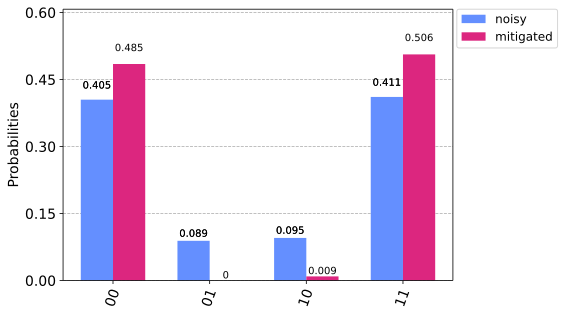

In [18]:
from qiskit.visualization import plot_histogram
%config InlineBackend.figure_format = 'svg' # Makes the images look nice
plot_histogram([noisy_counts, mitigated_counts], legend=['noisy', 'mitigated'])

ここでは、サンプルのほぼ$20\%$が誤った状態にある結果を取得し、それを正確な本来の結果の表現に変えました。ただし、この例には、単純なノイズモデルを持つ2量子ビットしかありません。より多くの量子ビット、およびより複雑なノイズモデル、または実デバイスからのデータの場合、エラー軽減はより多くの課題を抱えています。もしかしたら、あなたがQiskitが使用する方法よりも優れた方法を見つけられるかもしれません！

In [19]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.14.2',
 'qiskit-aer': '0.5.2',
 'qiskit-ignis': '0.3.3',
 'qiskit-ibmq-provider': '0.7.2',
 'qiskit-aqua': '0.7.3',
 'qiskit': '0.19.6'}